In [1]:
import os
import random
import numpy as np
import pandas as pd

# sklearn and imblearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE

# For reproducibility
def set_seed(seed_value=42):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    # If you use TensorFlow or PyTorch, set their seeds here as well.

set_seed(42)


In [2]:
# 1. Load the dataset
df = pd.read_csv("dataset.csv")  # Replace with your actual filename/path

# 2. Identify your target column
target_column = 'stress_level'
if target_column not in df.columns:
    raise ValueError(f"'{target_column}' column not found in dataset columns: {df.columns.tolist()}")

# If target is categorical strings, label-encode
if df[target_column].dtype == object:
    le = LabelEncoder()
    df[target_column] = le.fit_transform(df[target_column])

# 3. Choose the features (X) vs. the target (y)
X = df.drop(target_column, axis=1)
y = df[target_column]

# 4. Handle missing values if needed
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# 5. Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# 6. Handle class imbalance with SMOTE (optional, but recommended if classes are imbalanced)
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_scaled, y)

# 7. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.2,
    random_state=42,
    stratify=y_resampled
)


In [3]:
# Define models
svm_model = SVC(probability=True, random_state=42)
knn_model = KNeighborsClassifier()
nb_model = GaussianNB()
mlp_model = MLPClassifier(random_state=42, early_stopping=True)

# Define parameter grids for each model
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan, 2 for Euclidean
}

param_grid_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]
}

param_grid_mlp = {
    'hidden_layer_sizes': [(64, 32), (64, 32, 16)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'max_iter': [200, 300]  # Increase if needed
}

# Set up the GridSearchCV for each model
gs_svm = GridSearchCV(svm_model, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
gs_knn = GridSearchCV(knn_model, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
gs_nb = GridSearchCV(nb_model, param_grid_nb, cv=5, scoring='accuracy', n_jobs=-1)
gs_mlp = GridSearchCV(mlp_model, param_grid_mlp, cv=5, scoring='accuracy', n_jobs=-1)


In [4]:
grid_searches = {
    "SVM": gs_svm,
    "KNN": gs_knn,
    "NaiveBayes": gs_nb,
    "MLPClassifier": gs_mlp
}

best_models = {}
results = []

for model_name, gs in grid_searches.items():
    print(f"Running GridSearch for {model_name}...")
    gs.fit(X_train, y_train)
    best_models[model_name] = gs.best_estimator_
    
    # Evaluate on the test set
    y_pred = gs.best_estimator_.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    results.append({
        "model": model_name,
        "best_params": gs.best_params_,
        "best_cv_score": gs.best_score_,
        "test_accuracy": acc,
        "test_precision": prec,
        "test_recall": rec,
        "test_f1_score": f1
    })
    
    print(f"  Best Params: {gs.best_params_}")
    print(f"  Best CV Score: {gs.best_score_:.4f}")
    print(f"  Test Accuracy: {acc:.4f}\n")


Running GridSearch for SVM...
  Best Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
  Best CV Score: 0.8827
  Test Accuracy: 0.8304

Running GridSearch for KNN...
  Best Params: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
  Best CV Score: 0.8838
  Test Accuracy: 0.8393

Running GridSearch for NaiveBayes...
  Best Params: {'var_smoothing': 1e-07}
  Best CV Score: 0.8883
  Test Accuracy: 0.8661

Running GridSearch for MLPClassifier...
  Best Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32), 'max_iter': 200, 'solver': 'sgd'}
  Best CV Score: 0.8838
  Test Accuracy: 0.8661



In [5]:
results_df = pd.DataFrame(results)
results_df

# Pick best model based on highest test accuracy (you can choose another metric if you want)
best_overall = results_df.loc[results_df['test_accuracy'].idxmax()]
best_model_name = best_overall['model']
print("Best Overall Model:", best_model_name)



Best Overall Model: NaiveBayes


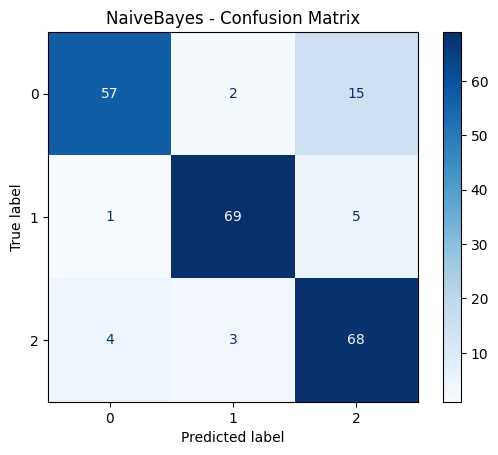

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

best_estimator = best_models[best_model_name]

y_test_pred = best_estimator.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"{best_model_name} - Confusion Matrix")
plt.show()


In [7]:
# Example single sample, adjust values according to your dataset columns
sample = {
    "anxiety_level": 3.2,
    "self_esteem": 2.1,
    "mental_health_history": 1.0,
    "depression": 4.0,
    "headache": 2.3,
    "blood_pressure": 120.0,
    "sleep_quality": 6.0,
    "breathing_problem": 0.0,
    "noise_level": 3.0,
    "living_conditions": 2.0,
    "safety": 3.0,
    "basic_needs": 2.0,
    "academic_performance": 3.0,
    "study_load": 4.0,
    "teacher_student_relationship": 4.0,
    "future_career_concerns": 3.0,
    "social_support": 4.0,
    "peer_pressure": 2.0,
    "extracurricular_activities": 1.0,
    "bullying": 0.0
}

# Convert to DataFrame
sample_df = pd.DataFrame([sample])

# Impute and scale (using the same pipeline from training)
sample_imputed = imputer.transform(sample_df)
sample_scaled = scaler.transform(sample_imputed)

pred = best_estimator.predict(sample_scaled)[0]
if hasattr(best_estimator, "predict_proba"):
    probs = best_estimator.predict_proba(sample_scaled)[0]
    confidence = probs[pred]
else:
    confidence = 1.0

print(f"Predicted Class: {pred}, Confidence: {confidence:.4f}")


Predicted Class: 1, Confidence: 1.0000
